In [1]:
import numpy as np
import pandas as pd


from NPIR import NPIR

from sklearn.utils import shuffle
from sklearn import datasets
from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn import metrics

import matplotlib.pyplot as plt

import datetime
import warnings
from collections import Counter as Cs
from timeit import default_timer as timer
from datetime import timedelta


import findspark
findspark.init()

########
from numpy import array
from math import sqrt
from pyspark.mllib.clustering import KMeans, KMeansModel
########

from pyspark import SparkContext
from operator import *
from pyspark import StorageLevel
from pyspark.sql.types import IntegerType, FloatType, BooleanType, StringType, StructType,\
StructField,ArrayType, DataType
from pyspark.sql.functions import udf, log, rand, monotonically_increasing_id, col, broadcast,\
greatest, desc, asc, row_number, avg, mean, least, struct, lit, sequence, sum
from functools import reduce
import pyspark.sql.functions as F
from pyspark.sql import SparkSession, SQLContext, Window, Row, DataFrame
from pyspark import SparkConf

In [2]:
spark = SparkSession.builder.master("local[*]").config("spark.sql.broadcastTimeout", "30000s").\
config("spark.network.timeout","30000s").config("spark.executor.heartbeatInterval","12000000ms").\
config("spark.storage.blockManagerSlaveTimeoutMs","12000001ms").config("spark.driver.maxResultSize","12g").\
config("spark.default.parallelism", "100").config("spark.memory.offHeap.enabled","true").\
config("spark.memory.offHeap.size", "14g").appName("NPIR_Parallel").getOrCreate()

In [3]:
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [4]:
# x1,y1 = make_blobs(n_samples=200000, centers=3, n_features=2,random_state=1)
# x1,y1 = datasets.make_circles(n_samples=15000,noise=0.05, random_state=1, factor=0.5)
# x1,y1 = make_moons(n_samples=1500, noise=0.05, random_state=1)
# data = pd.DataFrame(x1)
# data['label'] = y1
# data.head()

In [5]:
# data = shuffle(data)
# data.head()

In [6]:
# data.to_csv('blobs.csv', index=False)

In [7]:
# data.to_csv('circles.csv', index=False)

In [8]:
# data.to_csv('moons.csv', index=False)

In [9]:
#read csv
data_spark_df = spark.read.format('csv').option('header','False').option('index','False').load('varied.csv')
data_spark_df.show()

+------------+------------+---+
|         _c0|         _c1|_c2|
+------------+------------+---+
|-6.111197213| 1.471530617|  1|
|-7.496653612| 0.913425105|  1|
|-10.84489837|-7.553522727|  0|
|-4.543377252|-2.135686189|  1|
|-1.913820549|-0.034780433|  1|
| 1.771335217| 0.634508266|  2|
|-9.751573567|-5.203026198|  0|
|-11.51023635|-4.162843214|  0|
|-7.726757949|-5.866565634|  0|
| 2.307660856| 1.901931844|  2|
| 3.359375387| 0.090352097|  2|
| 1.508273199| 0.127569725|  2|
|-8.555451301|-5.035368003|  0|
|  2.04930912| 0.812644562|  2|
|-8.817189749|-4.579256337|  0|
| 0.538680593|-3.678825994|  1|
| 2.387060262| 1.139182088|  2|
| 1.533954825|-0.165970276|  2|
|-8.893149803|-5.327495942|  0|
|-7.035285456|-4.634899728|  0|
+------------+------------+---+
only showing top 20 rows



In [10]:
# data_spark_df = spark.read.format('csv').option('header','True').option('index','False').load('circles.csv')

In [11]:
# data_spark_df = spark.read.format('csv').option('header','True').option('index','False').load('moons.csv')

In [12]:
data_spark_df.describe()

DataFrame[summary: string, _c0: string, _c1: string, _c2: string]

In [13]:
data_spark_df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)



In [14]:
data_spark_df.show()

+------------+------------+---+
|         _c0|         _c1|_c2|
+------------+------------+---+
|-6.111197213| 1.471530617|  1|
|-7.496653612| 0.913425105|  1|
|-10.84489837|-7.553522727|  0|
|-4.543377252|-2.135686189|  1|
|-1.913820549|-0.034780433|  1|
| 1.771335217| 0.634508266|  2|
|-9.751573567|-5.203026198|  0|
|-11.51023635|-4.162843214|  0|
|-7.726757949|-5.866565634|  0|
| 2.307660856| 1.901931844|  2|
| 3.359375387| 0.090352097|  2|
| 1.508273199| 0.127569725|  2|
|-8.555451301|-5.035368003|  0|
|  2.04930912| 0.812644562|  2|
|-8.817189749|-4.579256337|  0|
| 0.538680593|-3.678825994|  1|
| 2.387060262| 1.139182088|  2|
| 1.533954825|-0.165970276|  2|
|-8.893149803|-5.327495942|  0|
|-7.035285456|-4.634899728|  0|
+------------+------------+---+
only showing top 20 rows



In [15]:
data_spark_df = data_spark_df.select('_c0', '_c1')

In [16]:
new_name = ['first', 'second']
data_spark_rdd = data_spark_df.toDF(*new_name).rdd.filter(lambda x:x)
data_spark_df = data_spark_df.toDF(*new_name)

In [17]:
data_spark_df.show()

+------------+------------+
|       first|      second|
+------------+------------+
|-6.111197213| 1.471530617|
|-7.496653612| 0.913425105|
|-10.84489837|-7.553522727|
|-4.543377252|-2.135686189|
|-1.913820549|-0.034780433|
| 1.771335217| 0.634508266|
|-9.751573567|-5.203026198|
|-11.51023635|-4.162843214|
|-7.726757949|-5.866565634|
| 2.307660856| 1.901931844|
| 3.359375387| 0.090352097|
| 1.508273199| 0.127569725|
|-8.555451301|-5.035368003|
|  2.04930912| 0.812644562|
|-8.817189749|-4.579256337|
| 0.538680593|-3.678825994|
| 2.387060262| 1.139182088|
| 1.533954825|-0.165970276|
|-8.893149803|-5.327495942|
|-7.035285456|-4.634899728|
+------------+------------+
only showing top 20 rows



In [18]:
spark.conf.set("spark.sql.debug.maxToStringFields", 1000)
spark.conf.set('spark.jars.packages','com.databricks:spark-cav_2.11')
spark.conf.set("spark.sql.parquet.compression.codec","gzip")
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "False")
sqlContext.setConf("spark.sql.shuffle.partitions", "100")

In [19]:
points = data_spark_df.count()
points

1500

In [20]:
#IR: The indexing ratio to be used for generating the maximum index
IR = 0.1
#The number of iteration i
i = 100
k = 3 #k: Number of clusters
# count = Cs()
chunk = 300

In [21]:
from pyspark.sql.functions import desc, row_number, monotonically_increasing_id
from pyspark.sql.window import Window

data_spark = data_spark_df.withColumn('index_column_name', row_number().\
                                          over(Window.orderBy(monotonically_increasing_id())) - 1)
# data_spark.show()

In [22]:
def unionAll(*dfs):
    return reduce(DataFrame.unionAll, dfs)

In [23]:
data_spark.columns

['first', 'second', 'index_column_name']

In [24]:
leaderheadr = ['chunkLabel', 'old label', 'count']
leaderheadr.extend([str(x) for x in range(1, len(data_spark.columns))])
leaderheadr = tuple(leaderheadr)
leaderheadr

('chunkLabel', 'old label', 'count', '1', '2')

In [25]:
labelsheader = ('chunkLabel', 'label')
labelsheader

('chunkLabel', 'label')

In [26]:
start = timer()


labels = sqlContext.createDataFrame([np.full(len(labelsheader), np.nan).tolist()],labelsheader)
labels = labels.na.drop()

leaders = sqlContext.createDataFrame([np.full(len(leaderheadr), np.nan).tolist()],leaderheadr)
leaders = leaders.na.drop()

ii = 0
for z in range(0, points, chunk):
    j = z + chunk
    data = data_spark.where(col("index_column_name").between(z, j-1)).toPandas()
    data.drop("index_column_name",axis=1,inplace=True)
    data = data.astype(float)
    from NPIR import NPIR
    label = NPIR(data.values,k,IR,i)
    data['labels'] = label
    
    # Adding to pyspard label
    chunklabel = np.full(len(label), ii).tolist()
    labelDF = [(x, y) for x, y in zip(chunklabel, label)]
    labelsDF = sqlContext.createDataFrame(labelDF,labelsheader)
    labels = unionAll(labels, labelsDF)

    leader = []
    f = list(Cs(label))
    f.sort()
    for i in f:
        leader.append([round(np.mean(z), 4) for z in data[data['labels']==i].values[:,:-1].T])
    del data
    del NPIR
    
    # Adding to pyspark leaders
    for x in range(len(leader)):
        x1 = [ii, x, Cs(label)[x]]
        x1.extend(leader[x])
        leader[x] = x1
    leaderDF = sqlContext.createDataFrame(leader,leaderheadr)
    leaders = unionAll(leaders, leaderDF)
    ii += 1
end = timer()
print ("Execution time HH:MM:SS:",timedelta(seconds=end-start))

Execution time HH:MM:SS: 0:00:26.522036


In [27]:
# # Load and parse the data
# data = sc.textFile("data/mllib/kmeans_data.txt")
# parsedData = data.map(lambda line: array([float(x) for x in line.split(' ')]))
parsedData = leaders.select(['1', '2']).rdd.map(list)

start = timer()
# Build the model (cluster the data)
clusters = KMeans.train(parsedData, k, maxIterations=20, initializationMode="random")
end = timer()
print ("Execution time HH:MM:SS:",timedelta(seconds=end-start))

Execution time HH:MM:SS: 0:00:20.996283


In [28]:
def squaree1(c,u,f,g):
    c = float(c)
    u = float(u)
    f = float(f)
    g = float(g)
    array1 = np.array([c,u])
    array2 = np.array([f,g])
    dist = np.linalg.norm(array1-array2)
    dist = dist.item()
    return dist

squaree_spark1 = udf(lambda x,y,z,r: squaree1(x,y,z,r), FloatType())
sqlContext.sql("SET spark.sql.autoBroadcastJoinThreshold = -1")

DataFrame[key: string, value: string]

In [29]:
# data_cent11 = sc.parallelize([])
start = timer()

spark_cluster_centroid = sqlContext.createDataFrame(([c.tolist() for c in clusters.centers]),\
                                                    ['cent_x', 'cent_y'])
spark_cluster_centroid = spark_cluster_centroid.withColumn('defined_cluster', row_number().\
                                          over(Window.orderBy(monotonically_increasing_id())) - 1)
data_cent11 = 0
for i in range(k):
    u = [ str(i)+'x',str(i)+'y']
    next_selected = spark_cluster_centroid.filter(col('defined_cluster') == str(i)).\
    drop('defined_cluster').toDF(*u)
    if i == 0:
        data_cent11 = data_spark_df.join(broadcast(next_selected))
#         print(data_cent.count())
        
        data_cent11 = data_cent11.withColumn(str(i),squaree_spark1(data_cent11.columns[0],\
                            data_cent11.columns[1],data_cent11.columns[i+2],data_cent11.columns[i+3]))
#         data_cent11.show()
        data_cent11 = data_cent11.drop(data_cent11.columns[i+2]).drop(data_cent11.columns[i+3])
#         data_cent11.show()
        data_cent11 = data_cent11.withColumn('mindist',col(str(i)))
#         data_cent11.show()
        data_cent11 = data_cent11.withColumn('mindist1',least(data_cent11.columns[i+2], col('mindist')))
#         data_cent11.show()
        data_cent11 = data_cent11.drop('mindist')
        data_cent11 = data_cent11.withColumnRenamed('mindist1','mindist')
    elif i > 0:
        data_cent11 = data_cent11.join(broadcast(next_selected))
#         data_cent11.show()
        data_cent11 = data_cent11.withColumn(str(i),squaree_spark1(data_cent11.columns[0],\
                                    data_cent11.columns[1], data_cent11.columns[i+3],data_cent11.columns[i+4]))
#         data_cent11.show()
        data_cent11 = data_cent11.drop(u[0]).drop(u[1])
#         data_cent11.show()
        data_cent11 = data_cent11.withColumn('mindist1',least(data_cent11.columns[i+3], col('mindist')))#4
#         data_cent11.show()
        data_cent11 = data_cent11.drop('mindist')
        data_cent11 = data_cent11.withColumnRenamed('mindist1','mindist')
#         next_cent = data_cent11.orderBy(desc('mindist')).limit(1).select(data_cent11.\
#                                                                          columns[:len(data_spark_df.columns)-1])#1:3
data_cent11 = data_cent11.drop('mindist')

# data_cent11.show()

In [30]:
def FindMinCOl( *row_list):
    ind = row_list.index(min(*row_list))
    return int(ind)
find_min_val_name = udf(FindMinCOl, IntegerType())

data_cent11 = data_cent11.withColumn('defined_cluster', find_min_val_name(*data_cent11.columns[2:3+k]))
data_cent11 = data_cent11.select('first','second','defined_cluster')

In [31]:
d = data_cent11.toPandas()

end = timer()
print ("Execution time HH:MM:SS:",timedelta(seconds=end-start))


Execution time HH:MM:SS: 0:00:03.187297


In [32]:
data = pd.read_csv('varied.csv',header=None)
data.head()

,0,1,2
0,-6.111197,1.471531,1
1,-7.496654,0.913425,1
2,-10.844898,-7.553523,0
3,-4.543377,-2.135686,1
4,-1.913821,-0.034780,1


In [33]:
# data = pd.read_csv('circles.csv')
# data.head()

In [34]:
# data = pd.read_csv('moons.csv')
# data.head()

In [35]:
data = data[[0,1,2]]

In [36]:
data['new'] = d['defined_cluster'].astype('int8')
data.head()

,0,1,2,new
0,-6.111197,1.471531,1,2
1,-7.496654,0.913425,1,2
2,-10.844898,-7.553523,0,0
3,-4.543377,-2.135686,1,0
4,-1.913821,-0.034780,1,1


In [37]:
y = data[2]
labelsPred = data['new']
# list(labelsPred)

In [38]:
x = data[[0,1]].values
x.shape

(1500, 2)

In [39]:
#printing results
print('labels:')
# print(labelsPred)

# tEnd = datetime.datetime.now()
# print('Time: ' + str(tEnd - tStart))
print('Measures:')
print('HS: ' + str(metrics.homogeneity_score(y,labelsPred)))
print('CS: ' + str(metrics.completeness_score(y,labelsPred)))
print('VM: ' + str(metrics.v_measure_score(y,labelsPred)))
print('AMI: ' + str(metrics.adjusted_mutual_info_score(y,labelsPred)))
print('ARI: ' + str(metrics.adjusted_rand_score(y,labelsPred)))

labels:
Measures:
HS: 0.6784959408955519
CS: 0.7047814089878849
VM: 0.6913889326059203
AMI: 0.6910060337583428
ARI: 0.6741758688894277


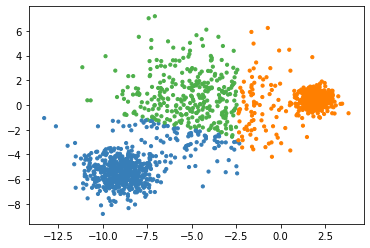

In [40]:
import matplotlib.pyplot as plt
from itertools import cycle, islice 

fig = plt.figure()      
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3',
                                    '#999999', '#e41a1c', '#dede00']),int(k))))
plt.scatter(x[:, 0], x[:, 1], s=10, color=colors[labelsPred.tolist()])
plt.show()
# plt.clf()